# Building a resillient image generation pipeline with Dall-E and Stability

[Portkey's open-source AI gateway](https://github.com/Portkey-AI/gateway) supports making calls to multiple Image models to generate images through a unified API. This notebook showcases the following functionality:

1. Generating an image through OpenAI
2. Generating an image through Stability
3. Setup a load balance between OpenAI and Stability, with a fallback to OpenAI's dall-e-2
4. Cache image requests for super fast loading

This notebook uses the OpenAI SDK to showcase the functionality. We're using the hosted AI gateway on [portkey.ai](https://portkey.ai), but you could swap with the open-source gateway for an [internally hosted gateway](https://portkey.ai/docs/product/ai-gateway-streamline-llm-integrations#open-source) as well.

In [ ]:
# Constants for use later - Please enter your own
PORTKEY_API_KEY="<PORTKEY_API_KEY>" # Get this from your -> Portkey Account profile > copy API key
OPENAI_API_KEY = "<OPENAI_KEY>" # Your OpenAI key from https://platform.openai.com/api-keys
STABILITY_API_KEY = "<STABILITY_API_KEY>" # Add your stability ai API key from https://platform.stability.ai/account/keys

In [ ]:
!pip install OpenAI
!pip install portkey-ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 70.6 MB/s eta 0:00:00


### 1. Generate an image using OpenAI

Let's try to make an image generation request to OpenAI through Portkey.

In [ ]:
from openai import OpenAI
from portkey_ai import PORTKEY_GATEWAY_URL, createHeaders
from IPython.display import display, Image

client = OpenAI(
    api_key=OPENAI_API_KEY,
    base_url=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        provider="openai",
        api_key=PORTKEY_API_KEY
    )
)

image = client.images.generate(
  model="dall-e-3",
  prompt="Lucy in the sky with diamonds",
  n=1,
  size="1024x1024"
)

# Display the image
display(Image(url=image.data[0].url))

This request went through Portkey's fast AI gateway which also then captures the information about the request on your Portkey Dashboard. On your logs screen, you'd be able to see this request like this

<img src="attachment:34be4d67-09c5-4db0-bdfc-7b144f09ca15.png" style="max-height: 400px;"/>

### 2. Generate an image using Stability AI
Let's try to make an image generation request to Stability through Portkey. Notice that we're going to use the OpenAI SDK itself to make calls to Stability AI as well

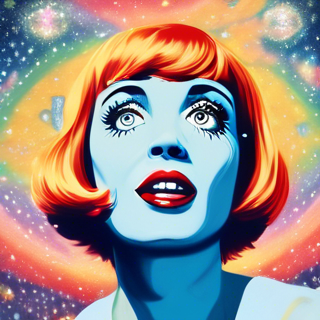

In [ ]:
from IPython.display import display, Image
import base64

client = OpenAI(
    api_key=STABILITY_API_KEY,
    base_url=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        provider="stability-ai",
        api_key=PORTKEY_API_KEY
    )
)

# Portkey will automatically convert this request to the format Stability expects
image = client.images.generate(
  model="stable-diffusion-v1-6",
  prompt="Lucy in the sky with diamonds",
  n=1,
  size="256x256"
)

# Since stability returns a base64 image string, we can display it like this
image_bytes = base64.b64decode(image.data[0].b64_json)
display(Image(data=image_bytes))

### 3. Use a config with load balancing & fallbacks
The AI gateway allows us to create routing configurations for better reliability across our requests. Lets take an example where we might want to loadbalance our requests equally between OpenAI's `dall-e-3` and Stability's `stable-diffusion-v1-6` with a overall fallback to `dall-e-2`

This requires us to create a config with a structure like this

```
fallback
    target1:
        loadbalance
            target1: dall-e-3
            target2: stable-diffusion-v1-6
    target2:dall-e-2
```

Let's define this using Portkey's configuration to achieve the same result. You can find more about configs [here](https://portkey.ai/docs/api-reference/config-object).

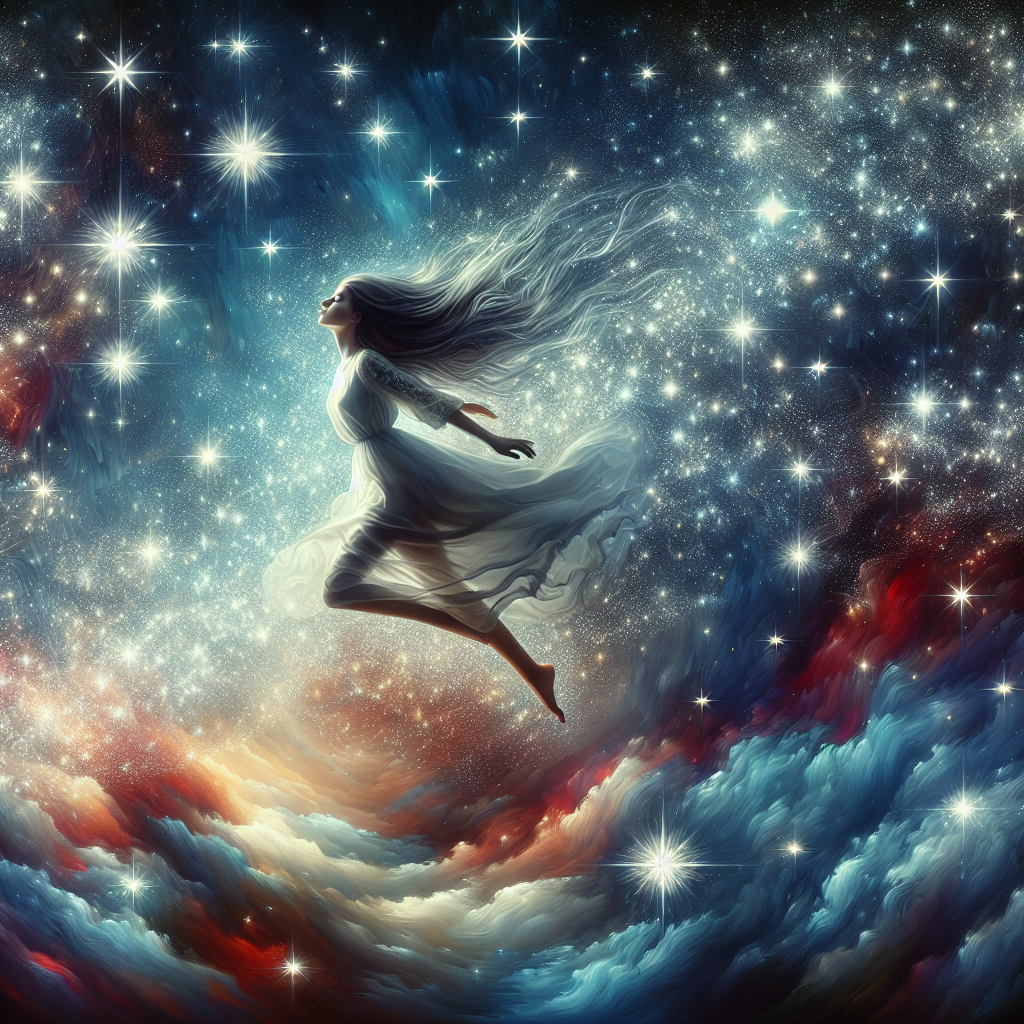

In [ ]:
# It is recommended to create this in the Portkey Config creator, but we're writing the config here to show the process
config = {
    "strategy": {
        "mode": "fallback"
    },
    "targets": [{
        "strategy": {
            "mode": "loadbalance"
        },
        "targets": [{
            "provider": "openai",
            "api_key": OPENAI_API_KEY,
        },{
            "provider": "stability-ai",
            "api_key": STABILITY_API_KEY,
            "override_params": {"model": "stable-diffusion-v1-6"}
        }]
    },{
        "provider": "openai",
        "api_key": "OPENAI_API_KEY",
        "override_params": {"model": "dall-e-2"}
    }]
}

client = OpenAI(
    api_key="X", # Not necessary since we''ll pick it up from the config
    base_url=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        config=config,
        api_key=PORTKEY_API_KEY
    )
)

image = client.images.generate(
  model="dall-e-3",
  prompt="Lucy in the sky with diamonds",
  response_format='b64_json',
  size="1024x1024"
)

# Display the image
image_bytes = base64.b64decode(image.data[0].b64_json)
display(Image(data=image_bytes))

The above image generated will follow your fallback and load balancing configurations making your app very resilient.

### 4. Cache Image Requests
The AI gateway also supports caching requests making them extremely fast. We could add cache to the above config and try the requests again.

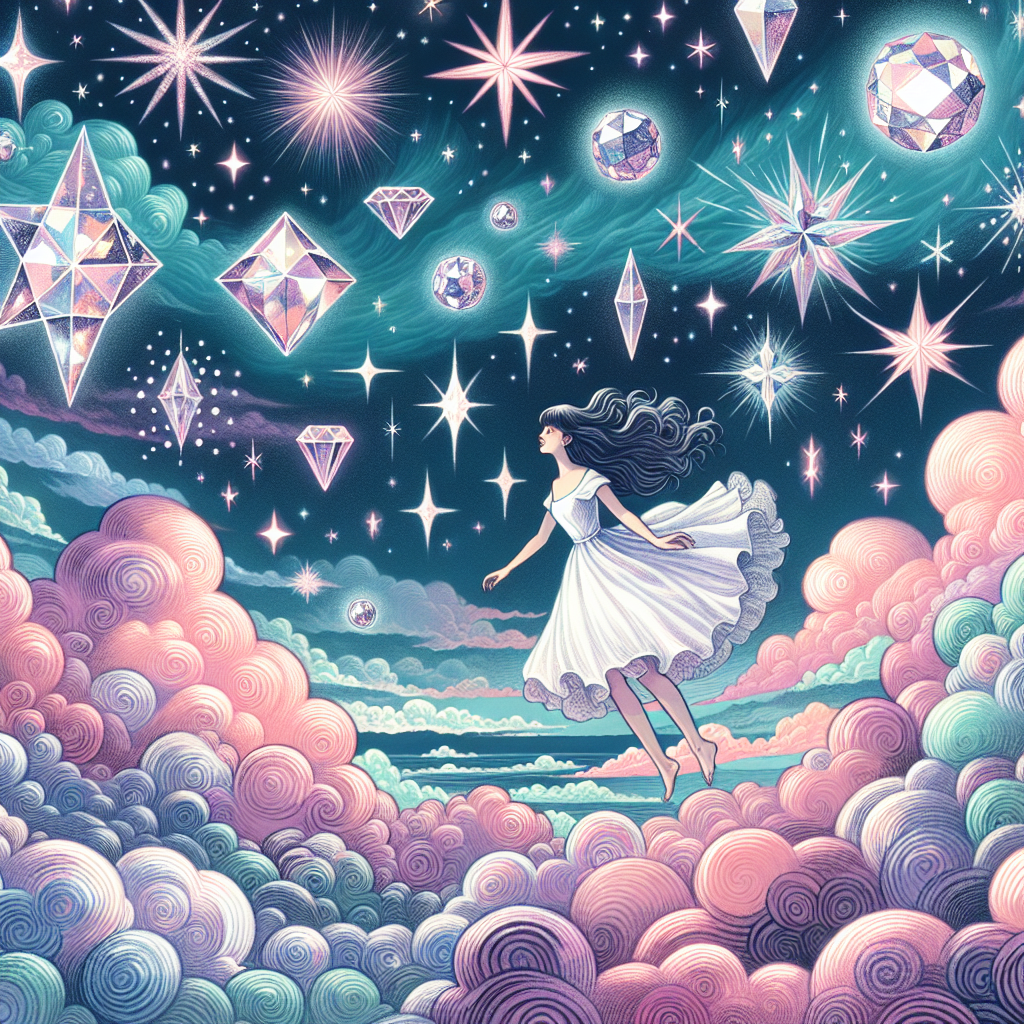

In [ ]:
# Add simple caching to the config defined above
config["cache"] = {"mode": "simple"}

client = OpenAI(
    api_key="X", # Not necessary since we''ll pick it up from the config
    base_url=PORTKEY_GATEWAY_URL,
    default_headers=createHeaders(
        config=config,
        api_key=PORTKEY_API_KEY
    )
)

image = client.images.generate(
  model="dall-e-3",
  prompt="Lucy in the sky with diamonds",
  response_format='b64_json',
  size="1024x1024"
)

# Display the image
image_bytes = base64.b64decode(image.data[0].b64_json)
display(Image(data=image_bytes))